In [1]:
from auto_ml_regression.automl_pipeline import AutoMLPipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import numpy as np
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

data = pd.read_csv('../../datasets/insurance_dataset/insurance.csv')
target_col="charges"
N_SEGMENTS = 2

cat_features = data.select_dtypes(include='object').columns.to_list()
num_features = data.select_dtypes(exclude='object').columns.to_list()
num_features.remove(target_col)
cat_features_saved = [f'CAT_{i}' for i in cat_features]

# Инициализация
pipeline = AutoMLPipeline(
    num_features=num_features,
    cat_features=cat_features,
    target_col=target_col,
    test_size=0.3,
    n_segments=N_SEGMENTS   # Можно указать любое количество сегментов
)

/Users/andrejurkinair/Documents/diploma_practice/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# График общего распределения целевого признака

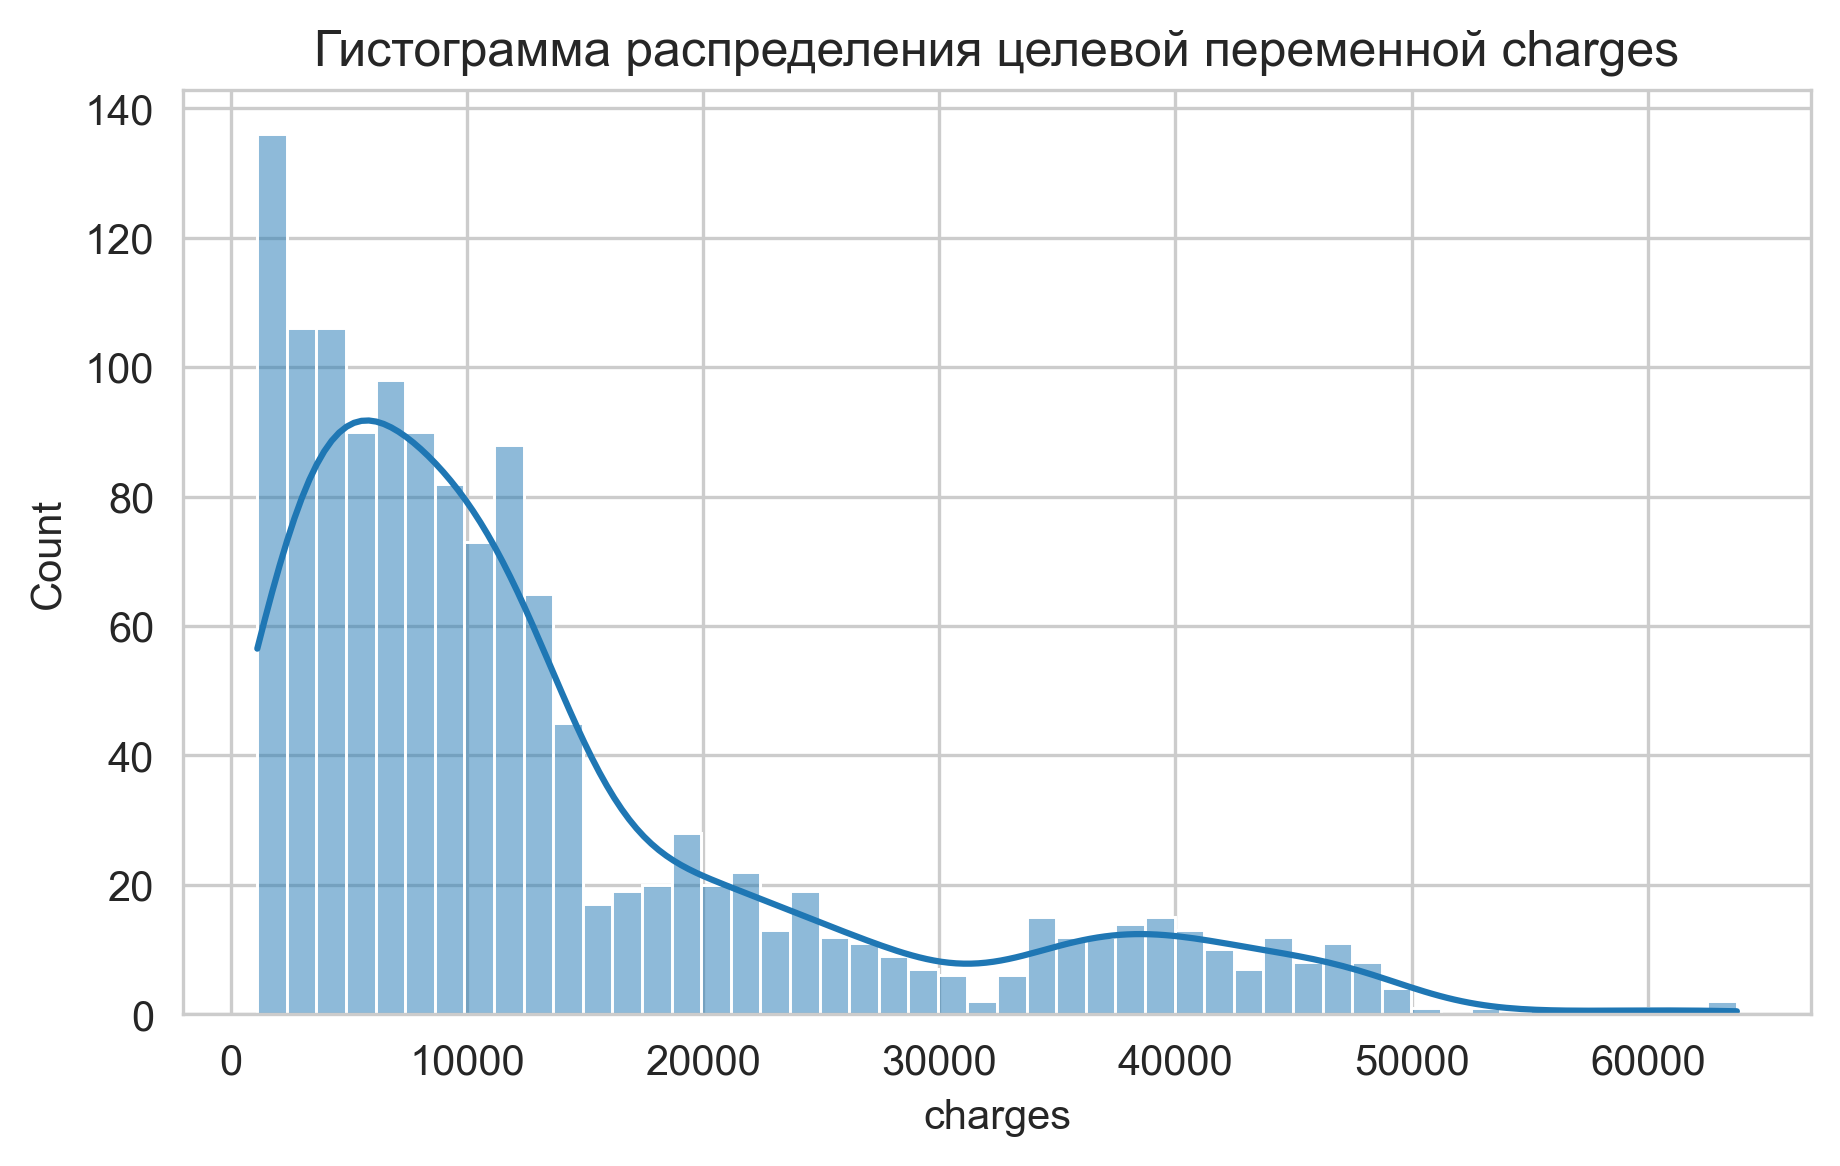

In [3]:
plt.figure(figsize=(7,4), dpi=300)
plt.title("Гистограмма распределения целевой переменной charges")
sns.set_style("whitegrid")
sns.histplot(data[target_col], bins=50, kde=True)
plt.show();

# Предобработка данных

In [2]:
# Запуск полного пайплайна
pipeline.preprocess_data(data)

In [3]:
train_df = pipeline.train_data
test_df = pipeline.test_data

In [4]:
train_df

,age,sex,bmi,children,smoker,region,CAT_sex,CAT_smoker,CAT_region,charges
0,0.021739,1.0,0.342653,0.0,1.0,0.000000,male,yes,northwest,17352.68030
1,0.630435,1.0,0.542010,0.2,0.0,0.321600,male,no,southwest,8068.18500
2,0.456522,0.0,0.225779,0.6,1.0,0.454797,female,yes,northeast,21659.93010
3,0.913043,1.0,0.455613,0.6,0.0,1.000000,male,no,southeast,13919.82290
4,0.739130,0.0,0.237243,0.4,1.0,1.000000,female,yes,southeast,24667.41900
...,...,...,...,...,...,...,...,...,...,...
931,0.521739,0.0,0.273592,0.0,1.0,0.000000,female,yes,northwest,21348.70600
932,0.173913,1.0,0.398434,0.0,0.0,0.000000,male,no,northwest,2699.56835
933,0.847826,1.0,0.674682,0.0,0.0,0.454797,male,no,northeast,11566.30055
934,0.804348,0.0,0.467496,0.4,0.0,0.000000,female,no,northwest,12269.68865


# OLS

In [5]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_df[num_features+cat_features], train_df[target_col])

LinearRegression()

In [6]:
from sklearn import metrics

y_true = test_df[target_col]
y_pred = lr.predict(test_df[num_features+cat_features])

r2 = metrics.r2_score(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

print(f"R2 = {r2}")
print(f"MSE = {mse}")
print(f"RMSE = {mse**0.5}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

R2 = 0.7187178036473286
MSE = 40067826.214164376
RMSE = 6329.915182225144
MAE = 4329.737045787503
MAPE = 0.43216080887704217


# Huber

In [ ]:
# 2. Определяем целевую функцию для Optuna
def objective(trial):
    # Предлагаем Optuna подбирать гиперпараметры
    epsilon = trial.suggest_float("epsilon", 1.0, 3.0, step=0.1)  # Оптимальный диапазон для epsilon
    alpha = trial.suggest_float("alpha", 0.0001, 1.0, log=True)    # Логарифмический масштаб для alpha

    # Создаем модель Huber с текущими гиперпараметрами
    model = HuberRegressor(epsilon=epsilon, alpha=alpha, max_iter=1000)

    # Используем кросс-валидацию (KFold) для оценки
    kf = KFold(n_splits=3, shuffle=True, random_state=2025)
    scores = cross_val_score(model, train_df[num_features+cat_features], train_df[target_col], 
                             cv=kf, scoring=make_scorer(mean_squared_error))
    
    scores_mae = cross_val_score(model, train_df[num_features+cat_features], train_df[target_col], 
                             cv=kf, scoring=make_scorer(mean_absolute_error))

    # Optuna минимизирует значение, поэтому берем средний MSE
    return np.mean(scores) + np.mean(scores_mae)

study = optuna.create_study(direction="minimize")  # Минимизируем MSE
study.optimize(objective, n_trials=50, show_progress_bar=False)
best_params = study.best_params

huber = HuberRegressor(max_iter=1000, **best_params)
huber.fit(train_df[num_features+cat_features], train_df[target_col])

/Users/andrejurkinair/Documents/diploma_practice/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-18 15:16:11,019] A new study created in memory with name: no-name-54e55be4-f38e-49c6-9d5d-5a952b49c098
[I 2025-05-18 15:16:11,038] Trial 0 finished with value: 141298812.859102 and parameters: {'epsilon': 3.0, 'alpha': 0.21865604282624765}. Best is trial 0 with value: 141298812.859102.
[I 2025-05-18 15:16:11,062] Trial 1 finished with value: 35838940.82485751 and parameters: {'epsilon': 2.6, 'alpha': 0.00015012757709527275}. Best is trial 1 with value: 35838940.82485751.
[I 2025-05-18 15:16:11,082] Trial 2 finished with value: 151147769.65430823 and parameters: {'epsilon': 1.6, 'alpha': 0.428980024449757}. Best is trial 1 with value: 35838940.82485751.
[I 2025-05-18 15:16:11,101] Trial 3 fin

HuberRegressor(alpha=0.00010426236317385542, epsilon=2.7, max_iter=1000)

In [8]:
y_true = test_df[target_col]
y_pred = huber.predict(test_df[num_features+cat_features])

r2 = metrics.r2_score(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

print(f"R2 = {r2}")
print(f"MSE = {mse}")
print(f"RMSE = {mse**0.5}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

R2 = 0.7189989227473056
MSE = 40027781.62055193
RMSE = 6326.751269059969
MAE = 4285.651436695592
MAPE = 0.4222008406676115


# Catboost 

In [17]:
import optuna
from catboost import CatBoostRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def objective(trial, X, y):
    # Разделение данных на train и validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2025)
    
    # Параметры для перебора
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'boosting_type': 'Plain',
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 255),
        'verbose': False,
        'random_state': 2025,
    }
    
    # Параметры глубины
    if params['grow_policy'] == 'Lossguide':
        params['max_leaves'] = trial.suggest_int('max_leaves', 4, 64)
    elif params['grow_policy'] == 'Depthwise':
        params['max_depth'] = trial.suggest_int('max_depth', 2, 12)
    
    # Указание категориальных признаков (если есть)
    if cat_features:
        params['cat_features'] = cat_features_saved
    
    # Создание и обучение модели
    model = CatBoostRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        verbose=0
    )
    
    # Предсказание на валидации
    y_pred = model.predict(X_val)
    
    # Метрика качества (можно выбрать другую)
    rmse = metrics.mean_squared_error(y_val, y_pred)**0.5
    # Или можно использовать R2: return r2_score(y_val, y_pred)
    return rmse

# Пример использования:
study = optuna.create_study(direction='minimize')  # Для RMSE минимизируем
study.optimize(lambda trial: objective(trial, 
                                     train_df[num_features+cat_features_saved], 
                                     train_df[target_col]), 
                                     n_trials=30)
best_params = study.best_params

[I 2025-05-18 15:29:45,327] A new study created in memory with name: no-name-38f8e827-b2f2-4831-966e-7c6f677cfb9c
[I 2025-05-18 15:29:46,049] Trial 0 finished with value: 4770.1579265482105 and parameters: {'iterations': 1789, 'learning_rate': 0.09536413875725806, 'l2_leaf_reg': 0.004076468760801953, 'random_strength': 0.001047668541841592, 'bagging_temperature': 0.31138119817397447, 'border_count': 92, 'min_data_in_leaf': 61, 'leaf_estimation_iterations': 13, 'grow_policy': 'SymmetricTree', 'od_type': 'IncToDec', 'od_wait': 43, 'one_hot_max_size': 221}. Best is trial 0 with value: 4770.1579265482105.
[I 2025-05-18 15:29:46,101] Trial 1 finished with value: 4465.620891128575 and parameters: {'iterations': 1001, 'learning_rate': 0.25928760042556764, 'l2_leaf_reg': 1.9195509615333035, 'random_strength': 8.30946848867066, 'bagging_temperature': 5.300663857239499, 'border_count': 68, 'min_data_in_leaf': 82, 'leaf_estimation_iterations': 14, 'grow_policy': 'Lossguide', 'od_type': 'Iter', 'o

In [18]:
cat_model = CatBoostRegressor(**best_params, cat_features = cat_features_saved, verbose = False,
        random_state= 2025, boosting_type='Plain')
cat_model.fit(train_df[num_features+cat_features_saved], train_df[target_col])

In [19]:
y_true = test_df[target_col]
y_pred = cat_model.predict(test_df[num_features+cat_features_saved])

r2 = metrics.r2_score(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

print(f"R2 = {r2}")
print(f"MSE = {mse}")
print(f"RMSE = {mse**0.5}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

R2 = 0.8393172621446607
MSE = 22888786.064268526
RMSE = 4784.222618594219
MAE = 2641.036051434736
MAPE = 0.2843348609375156


# My Pipeline

In [2]:
%%time

N_SEGMENTS=2
# Инициализация
pipeline = AutoMLPipeline(
    num_features=num_features,
    cat_features=cat_features,
    target_col=target_col,
    test_size=0.3,
    n_segments=N_SEGMENTS
)

# Запуск полного пайплайна
pipeline.preprocess_data(data)
pipeline.segment_data(plot=False)
pipeline.train_classifier(n_trials=10)
pipeline.train_regressors(model_type='huber', n_trials=50, cv=4)

[I 2025-05-18 15:40:21,935] A new study created in memory with name: no-name-5224b71c-ad41-45b4-aa30-02cd68df21d6
[I 2025-05-18 15:40:24,315] Trial 0 finished with value: -10490.265577527412 and parameters: {'depth': 3, 'learning_rate': 0.21830935754385344, 'l2_leaf_reg': 4.687922045817299}. Best is trial 0 with value: -10490.265577527412.
[I 2025-05-18 15:40:24,982] Trial 1 finished with value: -10149.412259206974 and parameters: {'depth': 3, 'learning_rate': 0.24209071286411568, 'l2_leaf_reg': 1.3416878123645044}. Best is trial 1 with value: -10149.412259206974.
[I 2025-05-18 15:40:25,563] Trial 2 finished with value: -11807.722206424756 and parameters: {'depth': 3, 'learning_rate': 0.046423826865363824, 'l2_leaf_reg': 4.016464862787883}. Best is trial 1 with value: -10149.412259206974.
[I 2025-05-18 15:40:26,130] Trial 3 finished with value: -11300.902157755008 and parameters: {'depth': 4, 'learning_rate': 0.11281192686992166, 'l2_leaf_reg': 4.43907392194819}. Best is trial 1 with v

Classification Report: TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       471
           1       1.00      1.00      1.00       465

    accuracy                           1.00       936
   macro avg       1.00      1.00      1.00       936
weighted avg       1.00      1.00      1.00       936

ROC AUC = 1.0
TEST ROC AUC = 1.0000


[I 2025-05-18 15:40:30,840] Trial 9 finished with value: -11361.590122371661 and parameters: {'epsilon': 2.459937120376541, 'alpha': 0.21172961614948418, 'fit_intercept': False}. Best is trial 1 with value: -7412.289950632347.
[I 2025-05-18 15:40:30,866] Trial 10 finished with value: -7449.557363374626 and parameters: {'epsilon': 1.0168093881012035, 'alpha': 0.14125258080426834, 'fit_intercept': True}. Best is trial 1 with value: -7412.289950632347.
[I 2025-05-18 15:40:30,891] Trial 11 finished with value: -7360.342168974392 and parameters: {'epsilon': 1.310521882111035, 'alpha': 0.1397553402851347, 'fit_intercept': True}. Best is trial 11 with value: -7360.342168974392.
[I 2025-05-18 15:40:30,915] Trial 12 finished with value: -7429.942682963499 and parameters: {'epsilon': 4.756662664360109, 'alpha': 0.16549775985625353, 'fit_intercept': True}. Best is trial 11 with value: -7360.342168974392.
[I 2025-05-18 15:40:30,940] Trial 13 finished with value: -7369.717354941062 and parameters: 

CPU times: user 9.11 s, sys: 7.58 s, total: 16.7 s
Wall time: 11.4 s


In [3]:
metrics_df = pipeline.evaluate_test()
metrics_df

,r2,mse,rmse,mae,mape
0,0.840371,2.273872e+07,4768.513243,2719.776359,0.276344


In [11]:
pipeline.regressor.get_model_coefs().to_csv('to_del.csv')

In [16]:
pipeline.segmented_train[pipeline.segmented_train['segment']==1][target_col].describe()

count      465.000000
mean     15660.659370
std      14623.216414
min       1135.940700
25%       5148.552600
50%       9880.068000
75%      20709.020340
max      63770.428010
Name: charges, dtype: float64

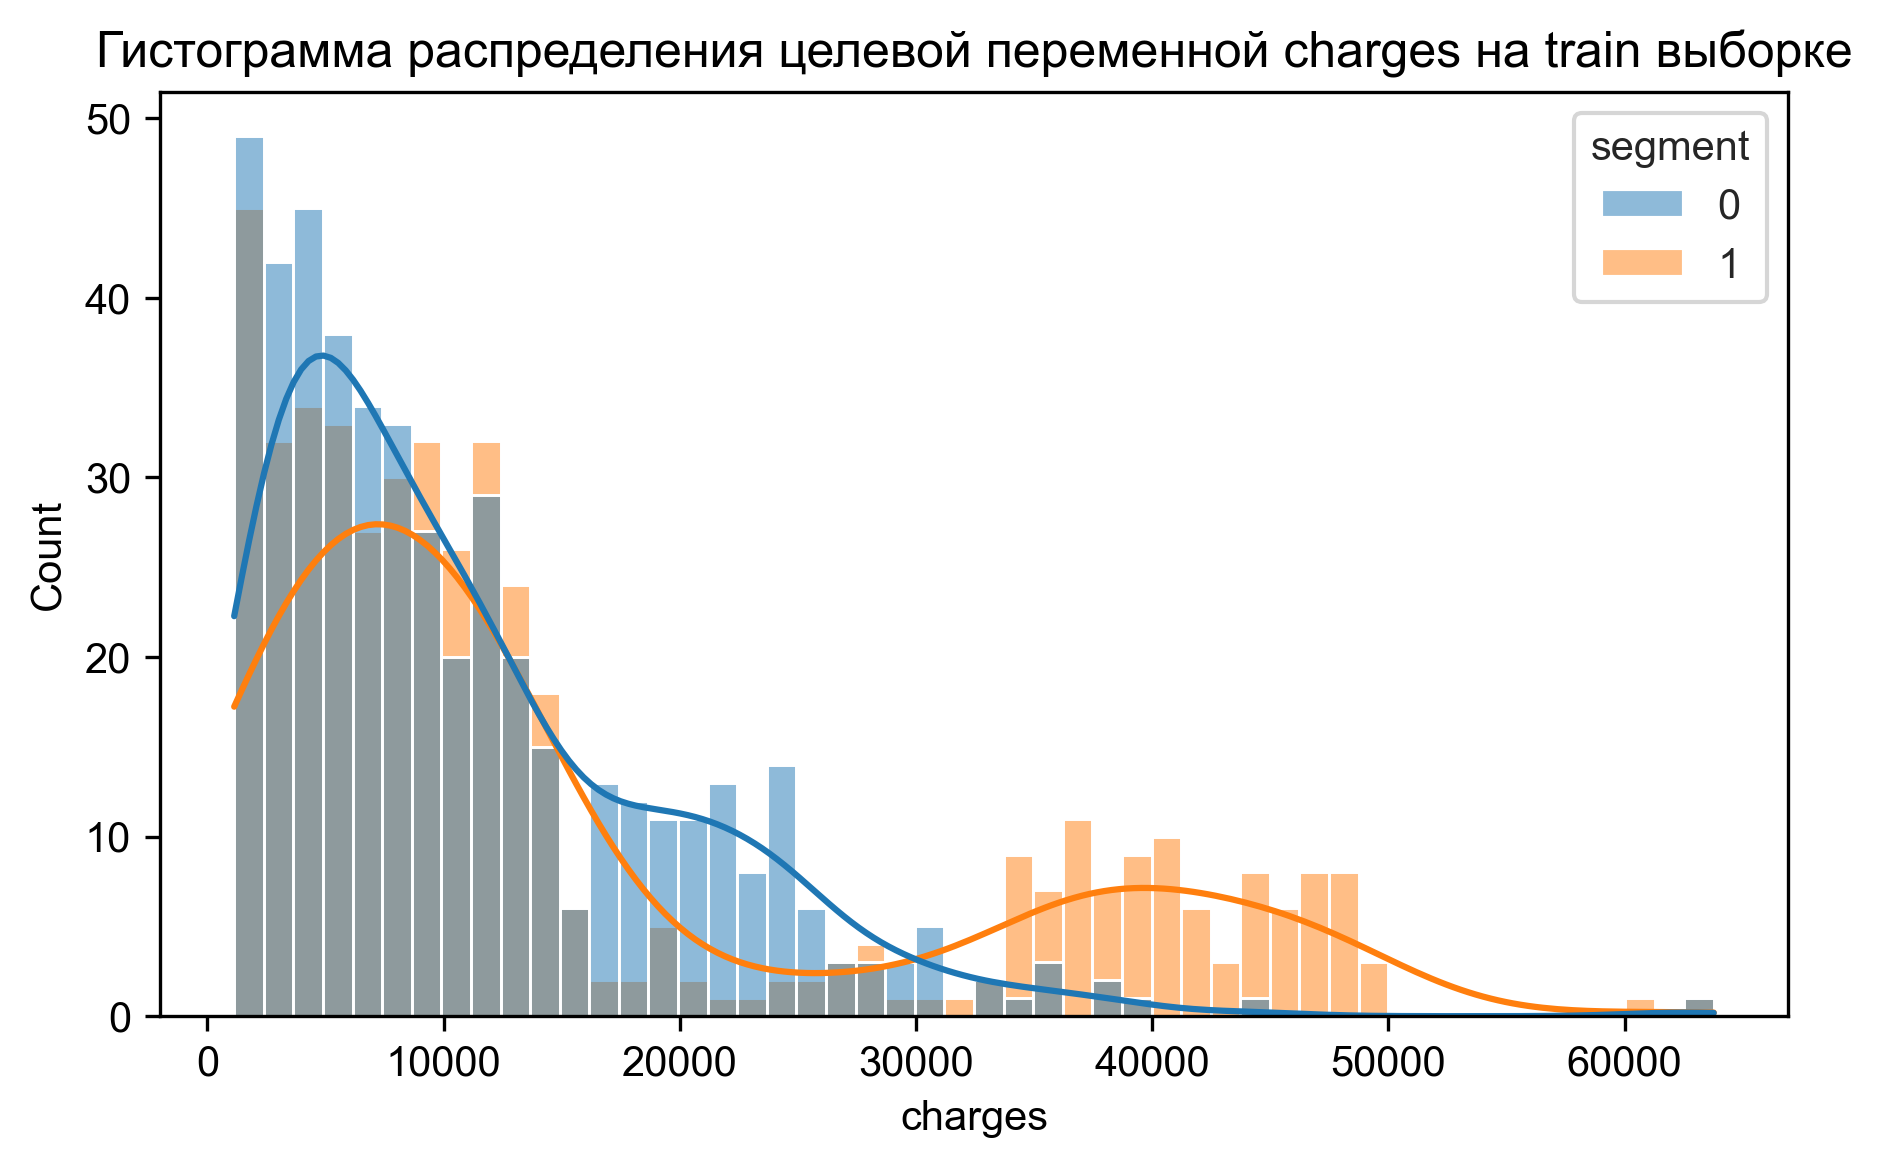

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4), dpi=300)
plt.title("Гистограмма распределения целевой переменной charges на train выборке")
sns.set_style("whitegrid")
sns.histplot(pipeline.segmented_train, x=target_col, hue='segment', bins=50, kde=True)
plt.show();

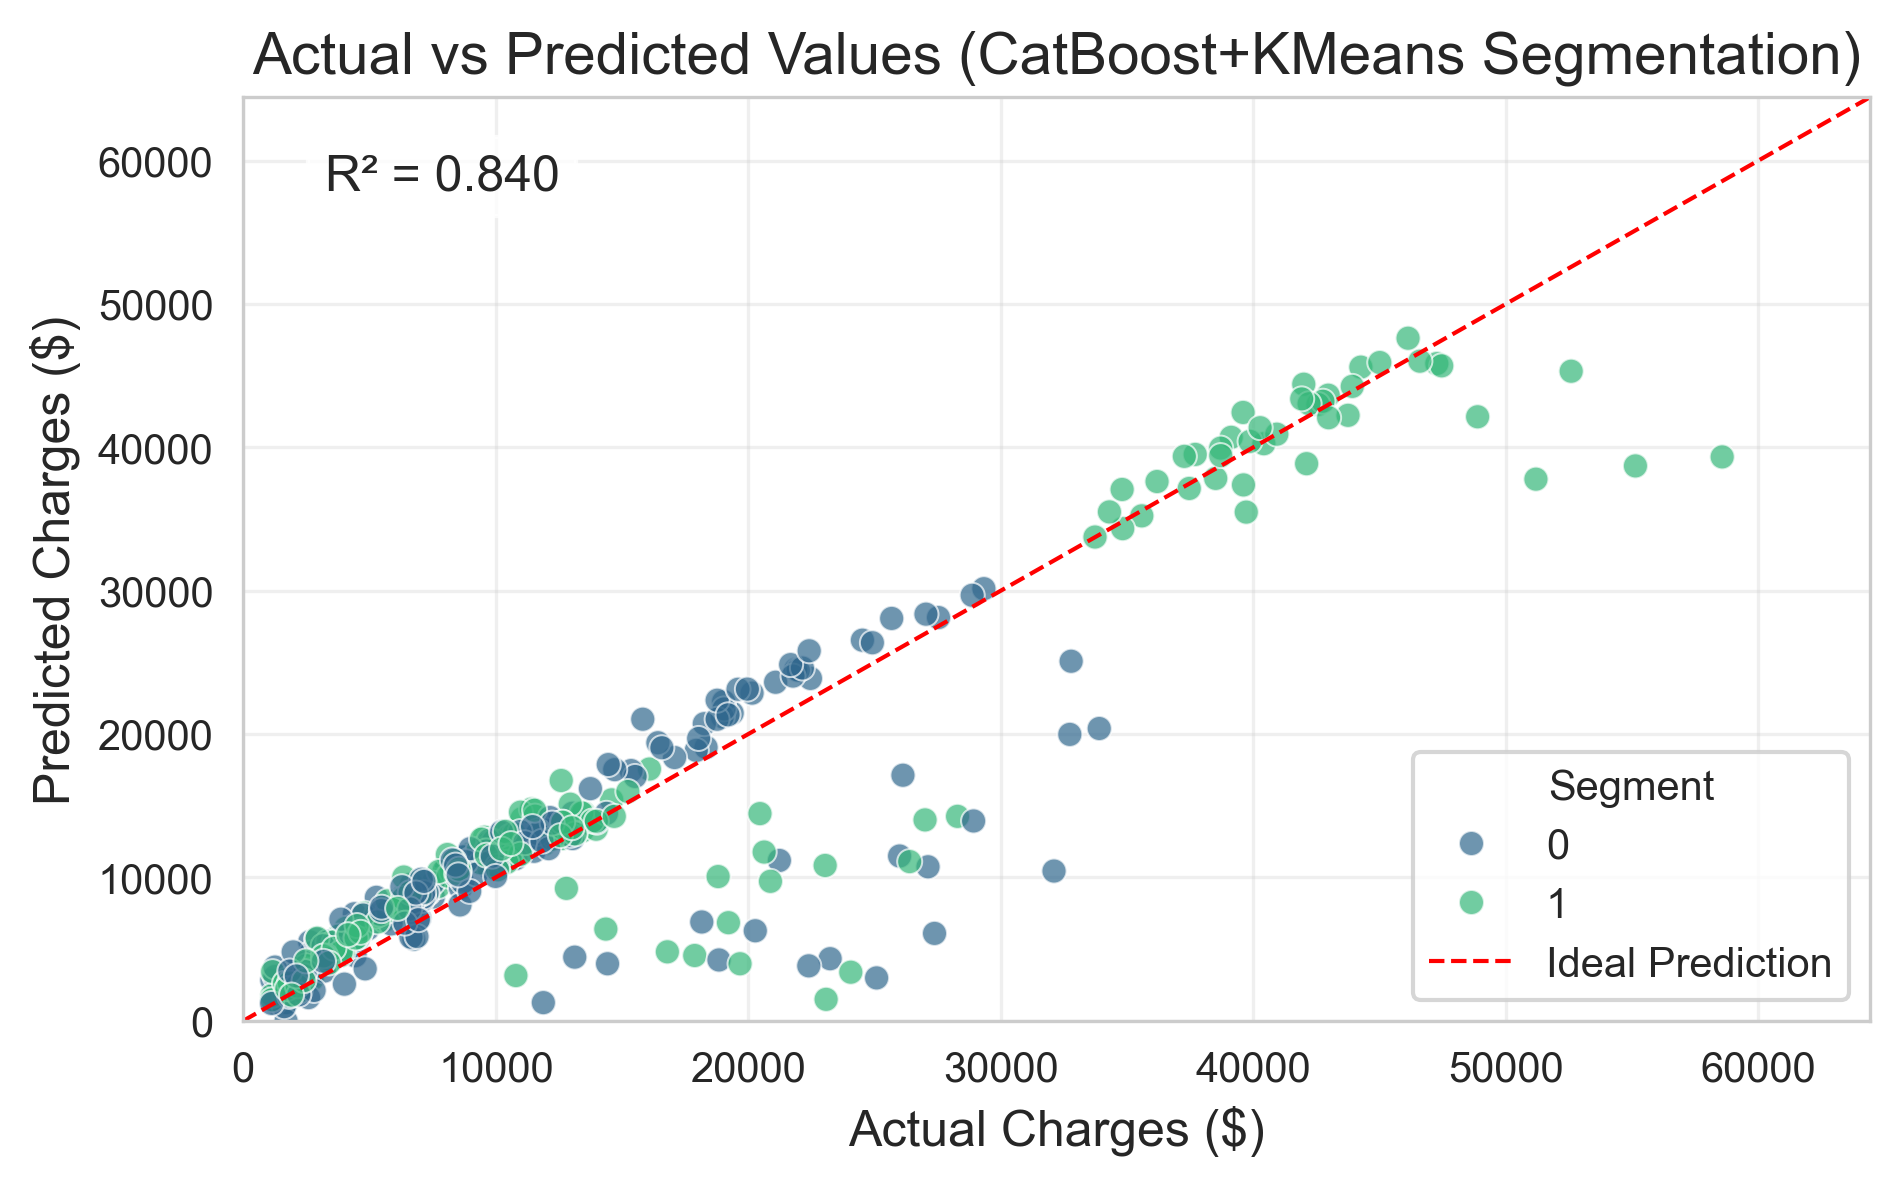

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

# Предположим, у нас есть:
# y_test - истинные значения на тестовой выборке
# y_pred - предсказания модели CatBoost+KMeans на тестовой выборке
y_test = pipeline.segmented_test[target_col]
y_pred = pipeline.regressor.predict(pipeline.segmented_test[num_features+cat_features], segments=pipeline.segmented_test['segment_preds'])

# Создаем DataFrame для визуализации
plot_data = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Segment': pipeline.segmented_test['segment']  # Добавляем информацию о сегментах
})

# Определяем границы осей (минимальное/максимальное значение + 10%)
ax_min = min(y_test.min(), y_pred.min()) * 0.9
ax_max = max(y_test.max(), y_pred.max()) * 1.1

# Создаем фигуру
plt.figure(figsize=(7, 4), dpi=300)

# Диаграмма рассеяния с цветовым кодированием по сегментам
scatter = sns.scatterplot(
    data=plot_data,
    x='Actual',
    y='Predicted',
    hue='Segment',
    palette='viridis',
    alpha=0.7
)

# Добавляем идеальную линию
ideal_line = plt.plot(
    [ax_min, ax_max],
    [ax_min, ax_max],
    '--',
    color='red',
    linewidth=1,
    label='Ideal Prediction'
)

# Настройки графика
plt.title('Actual vs Predicted Values (CatBoost+KMeans Segmentation)', fontsize=14)
plt.xlabel('Actual Charges ($)', fontsize=12)
plt.ylabel('Predicted Charges ($)', fontsize=12)
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.legend(title='Segment')
plt.grid(True, alpha=0.3)

# Добавляем коэффициент R² в аннотацию
r2 = metrics.r2_score(y_test, y_pred)
plt.text(
    x=ax_max*0.05,
    y=ax_max*0.9,
    s=f'R² = {r2:.3f}',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.show()